In [1]:
from astropy.io import fits
import numpy as np
import matplotlib.pyplot as plt

import torch 
import torch.nn as nn 
import torch.nn.functional as F 
import torch.optim as optim

## some examples of how to read data and downsize

In [2]:
hdulist = fits.open('/Volumes/NO NAME/Maps/Om0.183_si0.958/WLconv_z1.00_0001r.fits')
hdulist.info()

Filename: /Volumes/NO NAME/Maps/Om0.183_si0.958/WLconv_z1.00_0001r.fits
No.    Name      Ver    Type      Cards   Dimensions   Format
  0  PRIMARY       1 PrimaryHDU       7   (1024, 1024)   float32   


In [3]:
hdudata = hdulist[0]
data = hdudata.data 

In [4]:
hdudata.shape

(1024, 1024)

In [5]:
hdudata.header

SIMPLE  =                    T / conforms to FITS standard                      
BITPIX  =                  -32 / array data type                                
NAXIS   =                    2 / number of array dimensions                     
NAXIS1  =                 1024                                                  
NAXIS2  =                 1024                                                  
EXTEND  =                    T                                                  
ANGLE   =                  3.5 / angle of the map in degrees                    

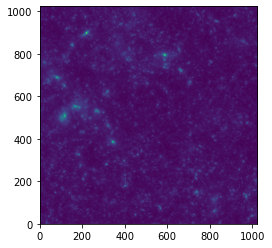

In [6]:
plt.imshow(hdudata.data, origin='lower')

In [7]:
# example of how to downsize 

l_original = int(data.shape[0])
l_downsized = int(l_original/2)
image_downsized = data.reshape([l_downsized, l_original//l_downsized, 
                                l_downsized, l_original//l_downsized]).mean(3).mean(1)

## Actual code for the network starts below

In [42]:
# read files 

# add your file path into rootpath before you proceed 
rootpath = ''
#rootpath = '/Volumes/NO NAME/Maps/Om0.183_si0.958/' <-- Gemma's testing file path

# these parameters are inherent to the image data 
n_imagespercosmo = 512  # number of images per cosmology 
n_perbatch = 32         # batch size 
n_batch = n_imagespercosmo/n_perbatch  # number of minibatches 
dim_image = 1024 
dim_downsized = int(dim_image/2)            # downsized image dimension 


# read in the files and put them into 3D matrix 
inputs = []

for i in range(1, 51): 
    if (i < 10): filenum = '00{}'.format(i)
    elif (i < 100): filenum = '0{}'.format(i)
    else: filenum = i
    
    hdulist = fits.open('{}WLconv_z1.00_0{}r.fits'.format(rootpath, filenum))
    image = hdulist[0].data
    
    # downsize from dim_image to dim_downsized 
    image_downsized = image.reshape([dim_downsized, dim_image//dim_downsized, 
                                dim_downsized, dim_image//dim_downsized]).mean(3).mean(1)
    
    # newaxis makes the image 3D (1x512x512) 
    inputs.append(image_downsized[np.newaxis,:,:])

In [43]:
# break the data into batches  

n_perbatch = 5  # this is a temp testing value to replace the default 32 per batch
target = torch.tensor([0.183, 0.958]).repeat(n_perbatch, 1)  # target value of sigma8 and omegam (stacked to the correct dimension to match the number per batch)

# make the data into 4D tensor and put each batch into iterable 
trainloader = torch.utils.data.DataLoader(np.array(inputs), batch_size=n_perbatch, shuffle=False)
train = iter(trainloader)

In [44]:
# network structure 

class Net (nn.Module):
    def __init__(self):
        super(Net, self).__init__()
        self.pool2 = nn.AvgPool2d(2, 2)
        self.pool4 = nn.AvgPool2d(4, 4)
        self.pool6 = nn.AvgPool2d(6, 6)
        
        self.conv1to32_5 = nn.Conv2d(1, 32, 5)
        self.conv32to64_5 = nn.Conv2d(32, 64, 5)
        self.conv64to128_5 = nn.Conv2d(64, 128, 5)
        self.conv128to256_5 = nn.Conv2d(128, 256, 5)
        self.conv256to512_5 = nn.Conv2d(256, 512, 5)
        self.conv512to256_5 = nn.Conv2d(512, 216, 5)
        self.conv256to512_3 = nn.Conv2d(216, 512, 3)
        
        self.fc = nn.Linear(512, 2)

    def forward(self, x):
        x = self.pool2(F.relu(self.conv1to32_5(x)))  # out: 254x254x32 
        x = self.pool2(F.relu(self.conv32to64_5(x)))  # out: 125x125x64 
        x = self.pool2(F.relu(self.conv64to128_5(x)))  # out: 60x60x128 
        x = self.pool2(F.relu(self.conv128to256_5(x)))  # out: 28x28x256 
        x = self.pool2(F.relu(self.conv256to512_5(x)))  # out: 12x12x512
        x = F.relu(self.conv512to256_5(x))  # out: 8x8x256 
        x = self.pool6(F.relu(self.conv256to512_3(x)))  # out: 6x6x512->1x1x512
        
        x = x.view(-1, 512)
        x = self.fc(x)
        return x
    
net = Net()

In [45]:
# loss function and training rate defined by paper 
criterion = nn.MSELoss()
optimizer = optim.SGD(net.parameters(), lr=0.005)

In [46]:
for epoch in range(2): 
    running_loss = 0.0 
    
    for i, data in enumerate(trainloader, 0):  
        optimizer.zero_grad()
        
        # forward + backward + optimize
        outputs = net(data)
        loss = criterion(outputs, target)
        loss.backward()
        optimizer.step()
        
        # .item() converts the tensor to a numpy number
        running_loss += loss.item()
         
        print('[%d, %5d] loss: %.3f' % (epoch + 1, i + 1, running_loss))

[1,     1] loss: 0.504
[1,     2] loss: 1.002
[1,     3] loss: 1.494
[1,     4] loss: 1.979
[1,     5] loss: 2.459
[1,     6] loss: 2.932
[1,     7] loss: 3.399
[1,     8] loss: 3.860
[1,     9] loss: 4.315
[1,    10] loss: 4.765
[2,     1] loss: 0.444
[2,     2] loss: 0.882
[2,     3] loss: 1.315
[2,     4] loss: 1.742
[2,     5] loss: 2.163
[2,     6] loss: 2.579
[2,     7] loss: 2.990
[2,     8] loss: 3.396
[2,     9] loss: 3.797
[2,    10] loss: 4.192
